In [2]:
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
import subprocess
from transformers import AutoModel, pipeline, Trainer, AutoTokenizer
import json
from datasets import Dataset, load_dataset, concatenate_datasets
import evaluate
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

c:\GitHub\PRPR\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/unixcoder-base")
model = AutoModel.from_pretrained("microsoft/unixcoder-base")

In [5]:
sampling_strategy = 1.0
rsmpl = RandomUnderSampler(sampling_strategy=sampling_strategy)

In [44]:

from tree_sitter import Language, Parser


CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')

parser = Parser()
parser.set_language(CPP_LANGUAGE)

c:\GitHub\PRPR\.venv\lib\site-packages\tree_sitter\__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


In [6]:
def get_index_code_dict(emb_ds):
    res_dict = {}
    
    for el in emb_ds:
        res_dict[el["index"]] = el["embedding"]
        
    return res_dict
    

In [7]:
#эмбеддинги для батча
def get_embeddings(inputs, model):
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1)
    return embeddings

In [8]:
def get_pairs_ds(emb_ds):
    id = 0
    print(len(emb_ds))
    id_1 = []
    id_2 = []
    is_same = []
    same_class = []
    for i in range(len(emb_ds)-1):
        id += 1
        if id % 100 == 0 or id == 10:
            print(id)
        for j in range(i+1, len(emb_ds)):
            id_1.append(i)
            id_2.append(j)
            are_same = emb_ds[i]["label"] == emb_ds[j]["label"]
            is_same.append(int(are_same))
            if are_same:
                same_class.append(emb_ds[i]["label"])
            else:
                same_class.append(-100)

    dataset = Dataset.from_dict({ "id_1":id_1,"id_2": id_2,
                                    "is_same": is_same, "same_class": same_class})
    return dataset

In [9]:
        
def get_similarities_ds(emb_ds, resampled_ds):
    X = []
    y = []
    for el in resampled_ds:
        conc_tensor = torch.cat([
            torch.Tensor(emb_ds[el["id_1"]]["embeddings"]),
            torch.Tensor(emb_ds[el["id_2"]]["embeddings"]),
            torch.Tensor(pairwise_distances(emb_ds[el["id_1"]]["embeddings"],emb_ds[el["id_2"]]["embeddings"],
                                                   metric='cosine'))
        ], dim=1)
        X.append(conc_tensor.view(-1))
        y.append(el["is_same"])
    X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.3, stratify=y, random_state=49)
    
    X_eval, X_test, y_eval, y_test = train_test_split(X_t, y_t, test_size=0.7, random_state=64)
    return X_train, X_eval, X_test, y_train, y_eval, y_test
        

In [11]:
def get_accuracy(emb_dataset):
    index_1 = []
    index_2 = []
    code_1 = []
    code_2 = []
    is_clones = []
    similarities = []
    for i in range(len(emb_dataset) - 1):
        i_label = emb_dataset[i]["label"]
        i_embeddings = torch.Tensor(emb_dataset[i]["embedding"][0]).reshape([1, -1])
        
        if i % 10 == 0:
            print(i)
            
        for j in range(i+1, len(emb_dataset)):
            j_label = emb_dataset[j]["label"]
            j_embeddings = torch.Tensor(emb_dataset[j]["embedding"][0]).reshape([1, -1])
            
            similarity = pairwise_distances(i_embeddings,j_embeddings,
                                                   metric='manhattan')
            
            index_1.append(emb_dataset[i]["index"])
            index_2.append(emb_dataset[j]["index"])
            code_1.append(emb_dataset[i]["res_code"])
            code_2.append(emb_dataset[j]["res_code"])
            is_clones.append(int(emb_dataset[i]["label"] == emb_dataset[j]["label"]))
            similarities.append(similarity)
            
    acc_dataset = Dataset.from_dict({ "index_1":index_1,"index_2": index_2, "is_clones": is_clones,
                                "similarities": similarities})
    return acc_dataset
    

In [12]:


def get_tokenized_dataset_orig(datafile, model):
    index = []
    label = []
    code = []
    code_1 = []
    code_2 = []
    bin_labels = []

    input_ids_1 = []
    input_ids_2 = []
    att_mask_1 = []
    att_mask_2 = []
    embeddings = []


    cnt = 0
    
    with open(datafile) as file:
            for line in file.readlines():
                
                cnt += 1   
                if cnt%100==0:
                    print(cnt)
                
                json_line = json.loads(line)
                index.append(int(json_line["index"]))
                label.append(int(json_line["label"]) - 1)
                clear_code = json_line["code"].replace("\r", "").replace("\n","").replace("\t","")
                
                code.append(clear_code)
                embeddings.append(get_embeddings(tokenizer(clear_code, max_length = 512, truncation=True, pad_to_max_length=True,  return_tensors='pt'), model))
                
    dataset = Dataset.from_dict({ "res_code":code,"index": index, 
                                 "embeddings": embeddings,
                                "label": label})
    return dataset

In [24]:
orig_code = get_tokenized_dataset_orig("rsm_test.jsonl", model)
orig_code.to_json("orig_code.jsonl")

100
200
300
400
500
600
700
800
900
1000
1100
1200


Creating json from Arrow format: 100%|██████████| 2/2 [00:00<00:00, 11.43ba/s]


12960446

In [25]:
orig_code = load_dataset("json", data_files = "orig_code.jsonl")["train"]
orig_code

Generating train split: 1200 examples [00:00, 20328.96 examples/s]


Dataset({
    features: ['res_code', 'index', 'embeddings', 'label'],
    num_rows: 1200
})

In [26]:
orig_code_pairs = get_pairs_ds(orig_code)
orig_code_pairs

1200
10
100
200
300
400
500
600
700
800
900
1000
1100


Dataset({
    features: ['id_1', 'id_2', 'is_same', 'same_class'],
    num_rows: 719400
})

In [27]:
orig_code_pairs.to_json("orig_code_pairs.jsonl")

Creating json from Arrow format: 100%|██████████| 720/720 [00:00<00:00, 811.89ba/s]


38846610

In [28]:
orig_code_pairs = load_dataset("json", data_files="orig_code_pairs.jsonl")["train"]
orig_code_pairs

Generating train split: 719400 examples [00:00, 3597012.01 examples/s]


Dataset({
    features: ['id_1', 'id_2', 'is_same', 'same_class'],
    num_rows: 719400
})

In [29]:
X = pd.DataFrame({"id_1": orig_code_pairs["id_1"], "id_2": orig_code_pairs["id_2"], "same_class": orig_code_pairs["same_class"]})

y = orig_code_pairs["is_same"]

X_resampled, y_resampled = rsmpl.fit_resample(X, y)

orig_code_pairs = Dataset.from_pandas(X_resampled)

orig_code_pairs = orig_code_pairs.add_column("is_same", y_resampled)

orig_code_pairs.to_json("orig_code_pairs.jsonl")



Creating json from Arrow format: 100%|██████████| 119/119 [00:00<00:00, 675.68ba/s]


9516109

In [30]:
orig_code_pairs

Dataset({
    features: ['id_1', 'id_2', 'same_class', '__index_level_0__', 'is_same'],
    num_rows: 118800
})

In [14]:

orig_code = load_dataset("json", data_files="orig_code.jsonl")["train"]
orig_code

Generating train split: 1200 examples [00:00, 14279.53 examples/s]


Dataset({
    features: ['res_code', 'index', 'embeddings', 'label'],
    num_rows: 1200
})

In [13]:

orig_code_pairs = load_dataset("json", data_files="orig_code_pairs.jsonl")["train"]
orig_code_pairs

Generating train split: 118800 examples [00:00, 1511419.64 examples/s]


Dataset({
    features: ['id_1', 'id_2', 'same_class', '__index_level_0__', 'is_same'],
    num_rows: 118800
})

In [15]:
print(len(orig_code_pairs.filter(lambda el: el["is_same"] == 1)) ==  len(orig_code_pairs.filter(lambda el: el["is_same"] == 0)))
print(len(orig_code_pairs))
print(len(orig_code_pairs.filter(lambda el: el["is_same"] == 1)))

Filter: 100%|██████████| 118800/118800 [00:00<00:00, 241449.67 examples/s]

True
118800
59400


In [16]:
X_train, X_eval, X_test, y_train, y_eval, y_test = get_similarities_ds(orig_code, orig_code_pairs)

In [17]:
print(len(X_train))
print(len(y_train))
print(len(X_eval))
print(len(y_eval))
print(len(X_test))
print(len(y_test))


83160
83160
10692
10692
24948
24948


In [18]:
len(list(filter(lambda el: el == 0, y_train))) == len(list(filter(lambda el: el ==1, y_train)))

True

Epoch: 1 Validation Accuracy: 0.7367190422745978
Epoch: 2 Validation Accuracy: 0.8109801720912833
Epoch: 3 Validation Accuracy: 0.8762626262626263
Epoch: 4 Validation Accuracy: 0.8946876169098391
Epoch: 5 Validation Accuracy: 0.8819678264122709
Epoch: 6 Validation Accuracy: 0.8477366255144033
Epoch: 7 Validation Accuracy: 0.9167601945379723
Epoch: 8 Validation Accuracy: 0.9261129816685372
Epoch: 9 Validation Accuracy: 0.9091844369622147
Epoch: 10 Validation Accuracy: 0.8841189674523008
Epoch: 11 Validation Accuracy: 0.9364010475121586
Epoch: 12 Validation Accuracy: 0.9135802469135802
Epoch: 13 Validation Accuracy: 0.8998316498316499
Epoch: 14 Validation Accuracy: 0.9452861952861953
Epoch: 15 Validation Accuracy: 0.9175084175084175
Epoch: 16 Validation Accuracy: 0.9389263000374112
Early stopping triggered at epoch 16


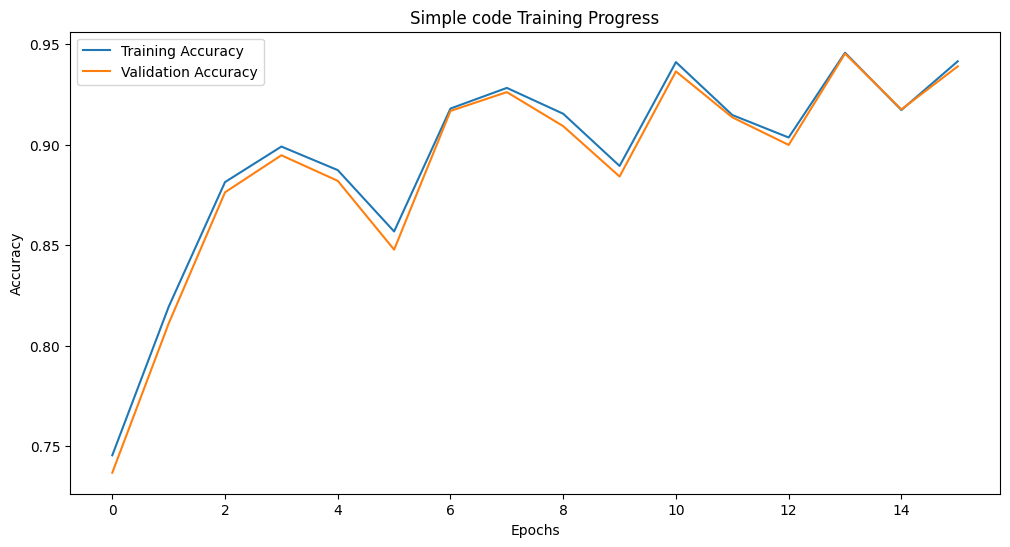

Accuracy: 0.9374298540965208
f1_score: 0.9347380743342113
простой_код


Creating json from Arrow format: 100%|██████████| 25/25 [00:00<00:00, 675.65ba/s]


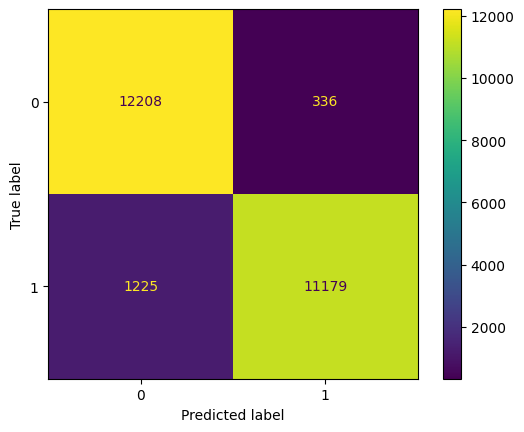

In [19]:
#классификационная голова с логированием

perceptron = Perceptron(tol=None, max_iter=1)

best_accuracy = 0
tol = 0.01
no_improvement = 0
max_no_improvement = 5

train_acc = []
val_acc = []

for epoch in range(1000):
    perceptron.partial_fit(X_train, y_train, classes=np.unique(y_train))
    
    y_pred_eval = perceptron.predict(X_eval)
    accuracy_eval = accuracy_score(y_eval, y_pred_eval)
    
    y_pred_train = perceptron.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    if accuracy_eval > best_accuracy + tol:
        best_accuracy = accuracy_eval
        no_improvement = 0
    else:
        no_improvement += 1
        
    train_acc.append(accuracy_train)
    val_acc.append(accuracy_eval)
    
    print('Epoch:', epoch+1, 'Validation Accuracy:', accuracy_eval)
    
    if no_improvement >= max_no_improvement:
        print('Early stopping triggered at epoch', epoch+1)
        break
    
    
title = "простой_код"
    
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Simple code Training Progress')
plt.legend()
plt.savefig('acc_график'+title+'prj.jpg')
plt.show()
    


y_pred = perceptron.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(title)
Dataset.from_dict({"orig":y_test, "prediction": y_pred}).to_json("простой_код_prediction.json")
plt.savefig('confusion_matrix_'+title+'prj.jpg')

Accuracy: 0.9172278338945006
f1_score: 0.9223304622559898
simple_code_EStop


Creating json from Arrow format: 100%|██████████| 25/25 [00:00<00:00, 999.45ba/s]


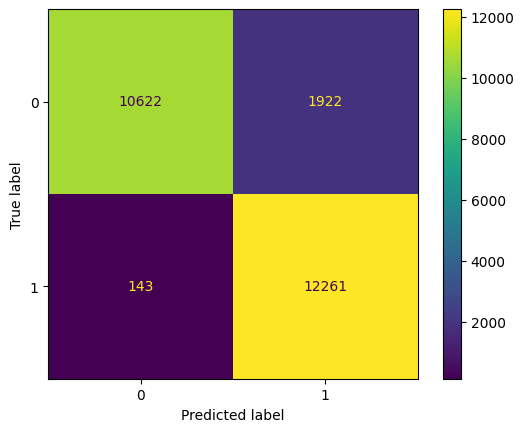

In [21]:
# классификационная голова без логирования с предостановкой

perceptron = Perceptron(early_stopping=True, tol=5, max_iter=1000)
perceptron.fit(X_train, y_train)

y_pred = perceptron.predict(X_test)


# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(cm).plot()
title = "simple_code_EStop"
print(title)
Dataset.from_dict({"orig":y_test, "prediction": y_pred}).to_json("simple_code_EStop_predicitons_2.json")
plt.savefig('confusion_matrix_'+title+'_2.jpg')


In [20]:
print(classification_report(y_test, y_pred, target_names=["не являются клонами", "являются клонами"]))

                     precision    recall  f1-score   support

не являются клонами       0.91      0.97      0.94     12544
   являются клонами       0.97      0.90      0.93     12404

           accuracy                           0.94     24948
          macro avg       0.94      0.94      0.94     24948
       weighted avg       0.94      0.94      0.94     24948

